In [2]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PlucQjxlzCWPTgIwwkd3L-N_RbQuuHv0' -O /content/sample_data/pca_plotter.py

--2020-06-17 02:56:36--  https://docs.google.com/uc?export=download&id=1PlucQjxlzCWPTgIwwkd3L-N_RbQuuHv0
Resolving docs.google.com (docs.google.com)... 108.177.126.113, 108.177.126.100, 108.177.126.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p8ojrj93i0tqlnq5j469jbq7atfqbl5a/1592362575000/04712700746129152962/*/1PlucQjxlzCWPTgIwwkd3L-N_RbQuuHv0?e=download [following]
--2020-06-17 02:56:36--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p8ojrj93i0tqlnq5j469jbq7atfqbl5a/1592362575000/04712700746129152962/*/1PlucQjxlzCWPTgIwwkd3L-N_RbQuuHv0?e=download
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04

In [21]:
%cd /content/sample_data/

/content/sample_data


In [22]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)


In [24]:
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
print(x_train.shape)

(60000, 784)


**Plotting data**

In [25]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

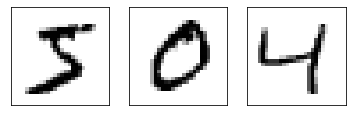

In [26]:
plot_triplets([x_train[0], x_train[1], x_train[2]])

In [27]:
def create_batch(batch_size=256):
    x_anchors = np.zeros((batch_size, 784))
    x_positives = np.zeros((batch_size, 784))
    x_negatives = np.zeros((batch_size, 784))
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_train.shape[0] - 1)
        x_anchor = x_train[random_index]
        y = y_train[random_index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y))
        indices_for_neg = np.squeeze(np.where(y_train != y))
        
        x_positive = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

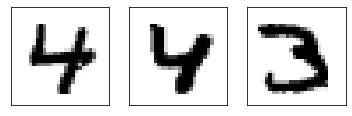

In [28]:
examples = create_batch(1)
plot_triplets(examples)

In [29]:
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(emb_size, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


In [30]:
example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(example)[0]

print(example_emb)

[0.3588785  0.3743211  0.48517624 0.5569958  0.29209408 0.49658573
 0.71369135 0.380104   0.5801359  0.52198786 0.49291176 0.47711733
 0.36657932 0.43490204 0.51311904 0.47614455 0.4309085  0.450925
 0.31411397 0.5161117  0.39308047 0.34603876 0.45500615 0.48227975
 0.560277   0.44120964 0.5323293  0.59256464 0.6137054  0.509394
 0.5289947  0.44325602 0.46806288 0.58847857 0.5557632  0.42748794
 0.61497056 0.41240954 0.34308836 0.5311608  0.58232975 0.64884055
 0.3860768  0.50029856 0.40717295 0.5292728  0.4978431  0.610114
 0.4272805  0.46190447 0.47018394 0.39721933 0.3098374  0.60520494
 0.5563436  0.60268295 0.66280365 0.5805925  0.49897394 0.56377786
 0.43459192 0.4027712  0.42082202 0.4630964 ]


In [31]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           54400       input_4[0][0]                    
                                                                 input_5[0][0]              

In [32]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [33]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

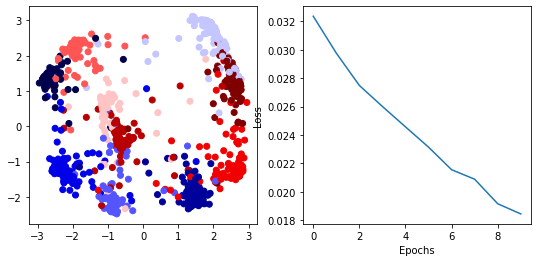

In [35]:
batch_size = 2048
epochs = 10
steps_per_epoch = int(x_train.shape[0]/batch_size)

net.compile(loss=triplet_loss, optimizer='adam')

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:1000], y_test[:1000]
        )]
)